## Wave Optics: ray tracing

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from src.ray import Ray
from src.lens import Lens
from src.window import Window
from src.visualizer import Visualizer

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 10)

In [3]:
def collimated_beam(start, width, nrays, angle=0):
    return [Ray(start, angle, z) for z in np.linspace(-width/2, width/2, nrays)]

In [17]:
beam = collimated_beam(0, 0.5, 10)
lens = Lens(0.5, 1, 1, 2.0)
fp = lens.focal_plane

In [18]:
lens_rays = lens.interact_with_bundle(beam)

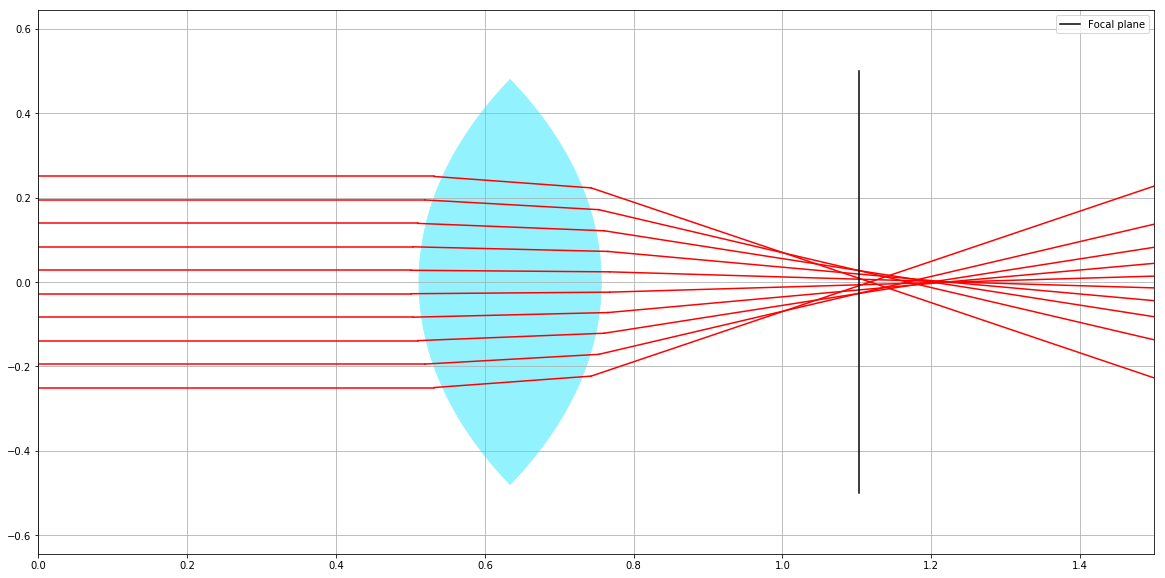

In [19]:
visualizer = Visualizer(beam + lens_rays, [lens], (1.5, 0.5))
visualizer.draw_all('r')
plt.plot([fp, fp], [-0.5, 0.5], color='black', label="Focal plane")
_ = plt.legend()